# Cadena de procesamiento

En este cuaderno veremos de manera sintética los procedimientos previos aplicados a la data de ejemplo "Precipitación 2". Se abarca la lectura de los datos, una presentación de los datos originales, el filtrado correspondiente, las transformaciones a tasa de precipitación y precipitación acumulada, la identificación de precipitación, y la caracterización de los datos de precipitación, como la amplitud espacial de las tormentas y su seguimiento. Sin embargo, aún no se muestran los procedimientos de identificación espacial. 

Para ello importamos las librerías correspondientes.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import wradlib as wrl
import Bases_GUI as radar
import utilidades as util

Importamos el archivo de análisis. En este caso usaremos "Precipitación 2", que corresponde a los datos del radar PIUXX el día 14/05/2019 15:20 hora UTC.

In [3]:
file = 'C:/Python37/Lluvia/2019051415200000dBuZ.azi'

Leemos los datos

In [4]:
radardata = radar.read_data(file)

Estamos interesados solo en la data original y no en analizar los metadatos, por ello en adelante trabajaremos con la matriz de datos.

In [5]:
dato = radardata.data['data']

Presentamos en pantalla los datos solo por una cuestión visual. En una cadena de procesamiento automática este proceso no es necesario, a menos que se encuentre implementada en tiempo real. 

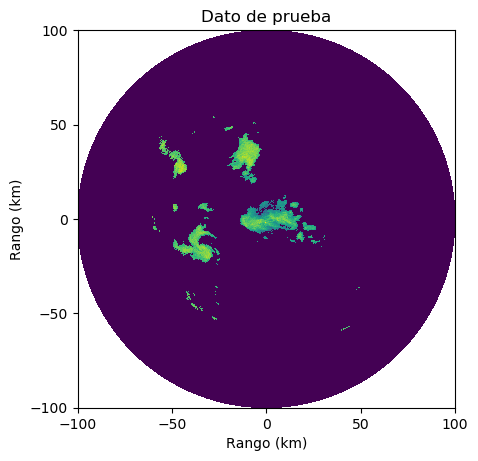

In [6]:
fig = util.ploteo(dato, rmax=100, title='Dato de prueba')

Tal vez la asignación hacia **`fig`** parezca extraña, pero proporciona facilidades para que las imágenes puedan ser guardadas en formato JPG o PNG sin problemas. Todo dependerá de la utilidad que se le dé al código.

Sólo para aclarar, lo que estoy haciendo son herramientas. Y como tal estás pueden ser usadas correctamente o no, por ello el lector debe asegurarse de entenderlas antes de aplicarlas. Mal utilizadas pueden realizar su función pobremente o en el peor de los casos introducir errores no previstos. No desligue el proceso de los resultados y sobre todo no use el código con la estúpida idea que este soluciona los problemas como por arte de magia. Aquí somos ingenieros, no magos, y los procesos se construyen sabiendo las cosas. Por ello tampoco se emocione de obtener resultados, eso cualquiera puede hacerlo, sino de tener buenos resultados.

<img src="Raven.gif">

Para el filtrado usaremos el procedimiento de mitigación. Para ello cargaremos algunos datos.

In [7]:
ruta = 'C:\Python37\Clutter'
clutterdata = util.dataclass(ruta)
Matriz = util.matriz3d(clutterdata)
    
Clutter_max = np.max(Matriz, axis=2)
Clutter_median = np.median(Matriz, axis=2)
Cadj = 1
Cluttermap = Clutter_median + Cadj

Estos archivos que nos sirven de referencia deberían ser encurtidos y cargados directamente para reducir su tiempo de ejecución. Dado que son externos a la cadena, su definición debe realizarse fuera de esta. 

In [8]:
datacorregida = util.mitigation(dato, Cluttermap, mask=True) 

Presentamos los resultados sólo porque esto es un cuaderno. 

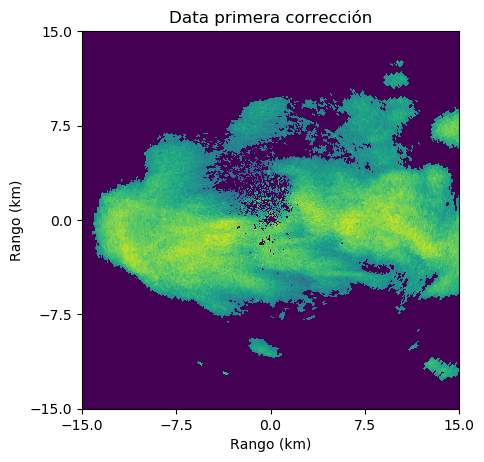

In [9]:
fig = util.ploteo(datacorregida, title='Data primera corrección', rmax=15)

Realizamos la corrección espacial usando el procedimiento de conectividad. 

In [10]:
cfilterholes = util.filter_conectivity(datacorregida, connect=12, mode='fill')

Dejaremos que el filtrado de Gabella se encarge de los objetos pequeños. 

In [11]:
datacorr2 = util.interpolation(datacorregida, cfilterholes, gabella=True, ipclass=wrl.ipol.Idw)

Vemos los resultados. Si se encuentra en una fase de evaluación, es probable que desee cambiar los parámetros. Si no tiene idea por donde comenzar puede optar por un proceso de búsqueda y/o evaluación iterativa. En ese caso, recomiendo ver los resultados usando el Clutter_max como referencia.

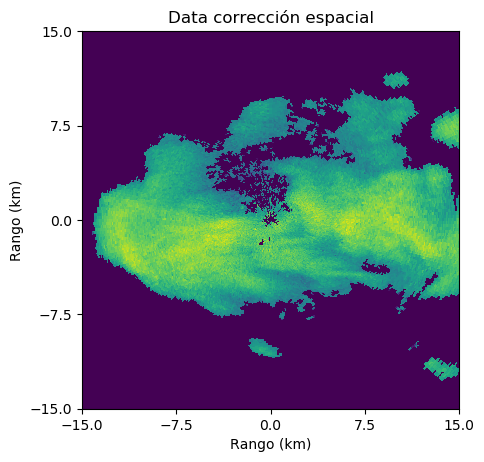

In [12]:
fig = util.ploteo(datacorr2, title='Data corrección espacial', rmax=15)

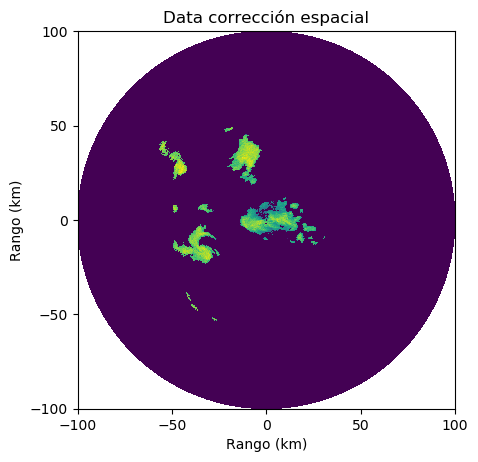

In [13]:
fig = util.ploteo(datacorr2, title='Data corrección espacial', rmax=100)

El siguiente proceso corresponde a la corrección de atenuación que sufre el radar de banda X. Lamentablemente, las configuraciones de este proceso particular escapan de mi conocimiento, pues su evaluación requiere datos de precipitación y objetivos sobre los cuales se pueda medir dicha atenuación. Es por ello que considero importante realizar algunas pruebas con ángulos de elevación donde se detecte la presencia de clutter lejano. Con ello, se pueden elaborar modelos para corregir la atenuación. En el estado que nos encontramos, podemos usar los algoritmos de corrección de atenuación de **`wradlib`** pero no podremos saber que tan bueno o malo es su desempeño. Se recomienda proceder con mucho cuidado si los datos de precipitación presentan reflectividades altas especialmente en las cercanías del radar. 

Si no sabe que hacer, puede obviarse este paso o implementar el algoritmo de Harrison que establece un límite para el PIA de un factor de `2` en precipitación(cerca de `4.8` dBZ en reflectividad). Este enfoque tal vez sea muy conservador pero evitará cualquier problema de inestabilidad. Si se prefiere otra buena opción controlada se puede implementar el método de Kraemer con restricciones (Kraemer modificado). 

En este caso, usaremos el algoritmo de Harrison. 

In [14]:
pia_harrison = wrl.atten.correct_attenuation_hb(datacorr2, coefficients = dict(a=4.57e-5, b=0.731, gate_length=1.0),
                                                mode="warn", thrs=59.)
pia_harrison[pia_harrison > 4.8] = 4.8
print('PIA máximo: {0:.3} dBZ'.format(pia_harrison.max()))

PIA máximo: 0.653 dBZ


Añadimos la atenuación a los datos:

In [15]:
data_final = datacorr2 + pia_harrison

Convertimos los datos a tasa de precipitación

In [16]:
R = wrl.zr.z_to_r(wrl.trafo.idecibel(data_final))

Este pequeño paso en el código, pero gran paso en la realidad oculta la complejidad de la transformación de los datos de reflectividad hacia tasas de precipitación. Por defecto se usa la ecuación de Marshall - Palmer, pero la calibración usando estaciones pluviométricas debería validar o rechazar esa suposición. Este paso es fundamental para pasar de la estimación cualitativa de los datos hacia su auténtica estimación cuantitativa. 

Si quisieramos el acumulado, este requiere el espaciamiento temporal de los datos.

In [17]:
time = 300 # Tiempo en segundos (5 minutos) 

Una manera de evitar errores es hallar este valor a través de la resta de los tiempos entre datos consecutivos, en caso se piense en la implementación en tiempo real. Otra cosa a considerar es que si se usan tiempos relativamente altos, los valores ya no representarán al intervalo y será mejor aproximación ignorarlos. 

In [18]:
depths = wrl.trafo.r_to_depth(R, time)

Una cosa más, dado que la función que se usa para la transformación de reflectividad a tasa de precipitación es de naturaleza exponencial, esta nunca será cero para los valores de reflectividad. Por ello es conveniente redondear los resultados a un nivel de precisión "verdadero".

In [19]:
print('Valor máximo:{} mm/h'.format(depths.max()))
print('Valor mínimo:{} mm/h'.format(depths.min()))

Valor máximo:0.21604660539886586 mm/h
Valor mínimo:3.2653144233068035e-05 mm/h


Conviene mantener una precisión de a lo mucho dos o tres decimales. Discusiones acerca de este tema pueden realizarse con algún hidrólogo para determinar la resolución en la que deberían mantenerse los datos.

In [20]:
R = np.round(R, decimals=3)
depths = np.round(depths, decimals=3)

In [21]:
print('Valor máximo:{} mm/h'.format(depths.max()))
print('Valor mínimo:{} mm/h'.format(depths.min()))

Valor máximo:0.216 mm/h
Valor mínimo:0.0 mm/h


Con eso hemos acabado con los datos. Pero para su presentación al público aún tienen que ser proyectados a una cuadrícula cartesiana. Aquí el trabajo se bifurca, la primera parte abordará la representación de los datos, mientras que la otra será de análisis de las características más importantes.

Para este proceso usaremos los datos correspondientes a R, pero puede usarse depths en su lugar. Todo dependerá de si quiere presentar tasas de precipitación o acumulados.

In [24]:
azi, r = util.ejes()
r = r * 1000 # La distancia debe usarse en metros
x200, y200 , grid200 = util.proyectar(R, r, azi, res=200, ipol = wrl.ipol.Idw, mask=True)

Mostramos los resultados de la interpolación. 

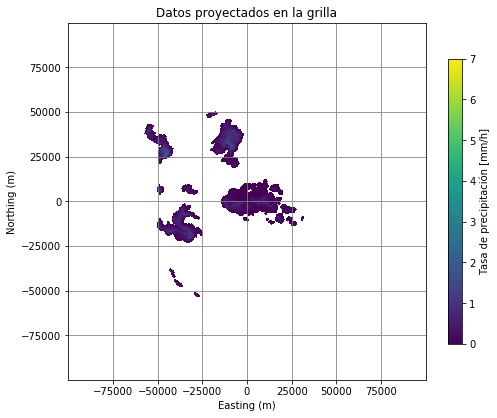

In [25]:
figure = plt.figure(figsize=(8,7))
figure = util.gridplot(figure, grid200, x200, y200, n=1, label='Tasa de precipitación [mm/h]', vmin=0, vmax=7)

**Nota:** Es importante para una presentación final de datos de manera continua establecer los valores de la escala a utilizar, de lo contrario esta será relativa a los datos y eso puede engañar al usuario. 

Si desea conservar el resto de datos puede no enmascarar los datos usando **`mask=False`** en la función **`util.proyectar`** 

Los datos serán proyectados al sistema geográfico WSG 84 para poder ser identificados con facilidad.

La presentación de los datos ya ha sido abordada en un cuaderno distinto, así que no tiene sentido volverla a hacer aquí. *Spoiler:* Si no supiste como resaltar los bordes usa una dilatación y "resta" los datos originales como primera aproximación. Existen funciones dedicadas en las librerías scipy.ndimage y skimage para mejores aproximaciones.

Los datos de la cuadrícula cartesiana serán usados para estimar el tamaño de las tormentas, su número y su posición relativa. 

Antes de ello, debemos asegurarnos que exista precipitación en los datos. Esto tal vez parezca una tontería, pero si se exploran los datos en una base de datos, sería ridículo una inspección visual para encontrar datos interesantes. Además en una implementación a tiempo real, resulta útil recibir avisos si es que existe precipitación o no, de tal forma que se puedan dar avisos sin necesidad de un usario. Esto dependerá del tipo de aviso que se quiera proporcionar(ya sea por umbral, zonal o lo que se le ocurra) y un primer paso para iniciar es determinar si hay o no precipitación.  

El tema de clasificación también ha sido colocado en un cuaderno distinto y su implementación sencilla evita que haga más comentarios al respecto. 

Ya con los datos procedemos a calcular el número de núcleos de tormenta así como su extensión. Esto es un poco difícil, porque, ¿cuantos núcleos de tormenta ve?

La pregunta no es trivial, y su respuesta determina la función a programar e implementar. Sin embargo, esto ya se ha abordado en un cuaderno anterior, por lo que aquí se utilizará la función directamente. 